# Description

In a [previous notebook](https://mimir.egroup.hu/posts/attila/linear-regression-step-by-step.html#) I implemented linear regression almost from scratch. In this notebook I will rewrite most parts of it training loop with Pytorch components one-by-one.

In this notebook I use Pytorch capablities such as [autograd](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html#:~:text=autograd%20is%20PyTorch's%20automatic%20differentiation,helps%20a%20neural%20network%20train.).

In this example we will predict the sepal length of the given 3 iris species from one of their other attributes.

# Data Acquisition

In [1]:
import pandas as pd

## Download Iris dataset

In [2]:
iris_url = "https://gist.githubusercontent.com/netj/8836201/raw/6f9306ad21398ea43cba4f7d537619d0e07d5ae3/iris.csv"

In [3]:
df = pd.read_csv(iris_url)

## Replace "." to "_" in column names

In [4]:
df.columns = [c.replace(".", "_") for c in df.columns]
df

,sepal_length,sepal_width,petal_length,petal_width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Virginica
146,6.3,2.5,5.0,1.9,Virginica
147,6.5,3.0,5.2,2.0,Virginica
148,6.2,3.4,5.4,2.3,Virginica


# Data Exploration

In [5]:
import matplotlib.pyplot as plt

## Scatter plot

From the scatterplot below we can see that sepal length mostly have linear dependence on the petal length feature.

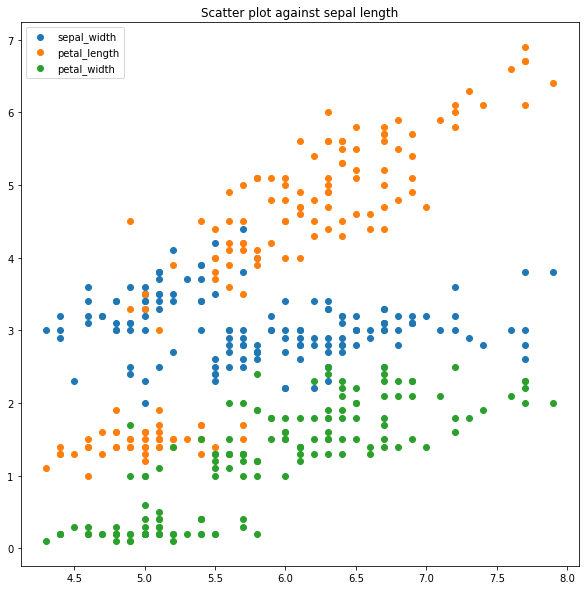

In [6]:
fig = plt.figure(figsize=(10,10))
plt.scatter(
    df["sepal_length"], 
    df["sepal_width"], 
    label="sepal_width"
)
plt.scatter(
    df["sepal_length"], 
    df["petal_length"], 
    label="petal_length"
)
plt.scatter(df["sepal_length"], 
            df["petal_width"], 
            label="petal_width"
)

plt.title('Scatter plot against sepal length')
plt.legend()

# Data preparation 

In [7]:
import numpy as np

## Normalization by mean

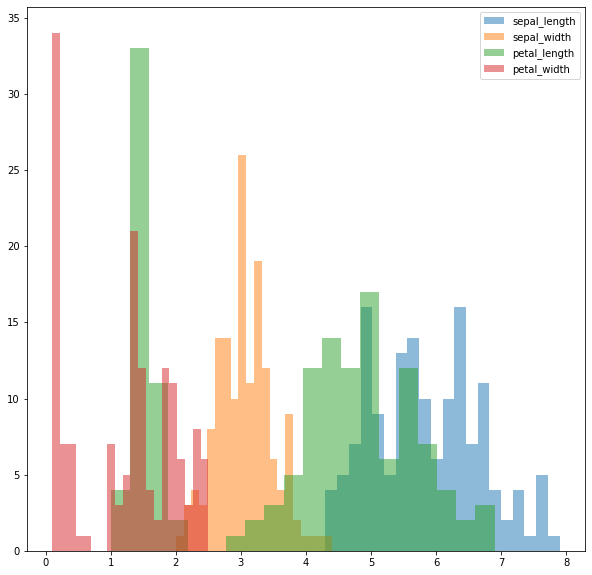

In [8]:
fig = plt.figure(figsize=(10,10))
for i, c in enumerate(df.iloc[:,:4].columns):
    plt.hist(df[c], bins=20, alpha=0.5, label=c)
plt.legend()
    

In [9]:
def normalize(x):
    x_avg = np.average(x)
    x_std = np.std(x)
    return (x - x_avg) / x_std
        

In [10]:
df_train = df.iloc[:,:4].apply(normalize).copy()
df_train

,sepal_length,sepal_width,petal_length,petal_width
0,-0.900681,1.019004,-1.340227,-1.315444
1,-1.143017,-0.131979,-1.340227,-1.315444
2,-1.385353,0.328414,-1.397064,-1.315444
3,-1.506521,0.098217,-1.283389,-1.315444
4,-1.021849,1.249201,-1.340227,-1.315444
...,...,...,...,...
145,1.038005,-0.131979,0.819596,1.448832
146,0.553333,-1.282963,0.705921,0.922303
147,0.795669,-0.131979,0.819596,1.053935
148,0.432165,0.788808,0.933271,1.448832


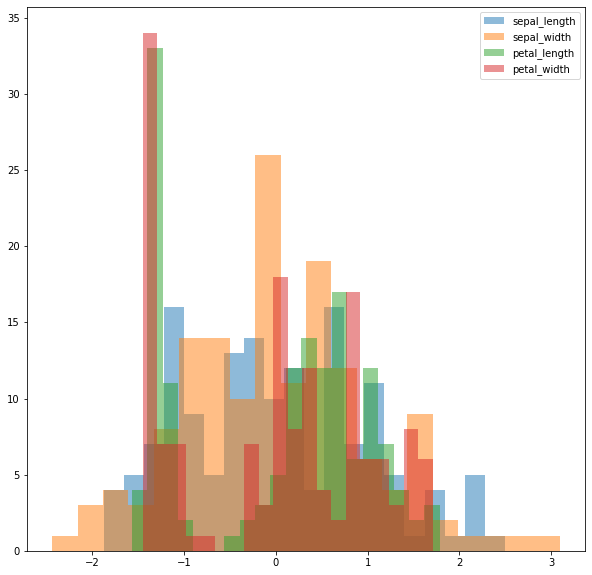

In [11]:
fig = plt.figure(figsize=(10,10))
for i, c in enumerate(df_train.iloc[:,:4].columns):
    plt.hist(df_train[c], bins=20, alpha=0.5, label=c)
plt.legend()
    

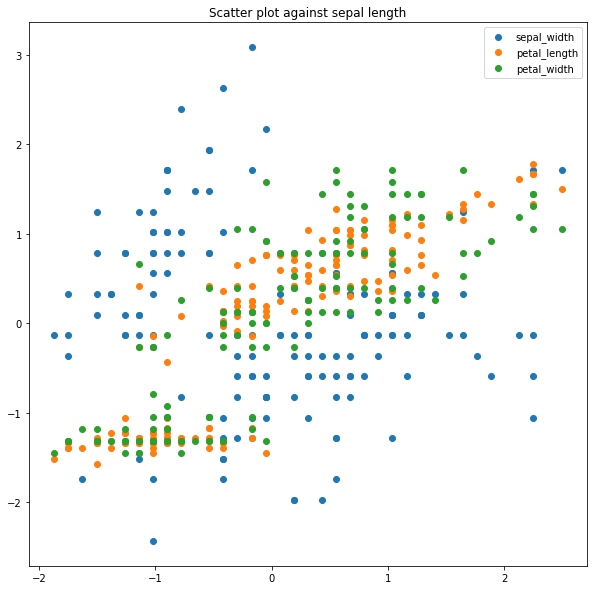

In [12]:
fig = plt.figure(figsize=(10,10))
plt.scatter(
    df_train["sepal_length"], 
    df_train["sepal_width"], 
    label="sepal_width"
)
plt.scatter(
    df_train["sepal_length"], 
    df_train["petal_length"], 
    label="petal_length"
)
plt.scatter(
    df_train["sepal_length"], 
    df_train["petal_width"], 
    label="petal_width"
)

plt.title('Scatter plot against sepal length')
plt.legend()

# Training

In [13]:
import torch

## Model

We assume that sepal length is linearly dependent on petal length. So our model is a simple line defined by two parameters, its slope a.k.a as the weight of the input and intersection of the y axis a.k.a as the bias.

Linear model/function
$$
M = m(x)_{w,b} = wx + b
$$

In [14]:
def model(x, w, b):
    return w*x + b

Input:

- `x` is the input tensor

Output:

- `M` is the output tensor, model prediction

Parameters:

- `w` is the weight parameter
- `b` is the bias parameter

The parameters in this case will be scalars, so 0 dimensional tensors.

## Loss function 

Mean Square Loss

$$
L = l(M, T) = \frac {\sum_{i=1}^{N} (M_{i} - T_{i})^{2}} {N}
$$



In [17]:
def l(M, T):
    squared_differnces = (M - T)**2
    return squared_differnces.mean()

## Training loop

### Training loop with autograd

In [35]:
EPOCHS = 10
LEARNING_RATE = 1e-1

In the [previous training loop](https://mimir.egroup.hu/posts/attila/linear-regression-step-by-step.html#Training-Loop) I handcrafted the gradient descent. Here I will use the autograd engine of Pytorch to automatically calculate the gradients instead of the previous [handcrafted gradient function](https://mimir.egroup.hu/posts/attila/linear-regression-step-by-step.html#Gradient-Function). The optimalization part itself is still handcrafted.


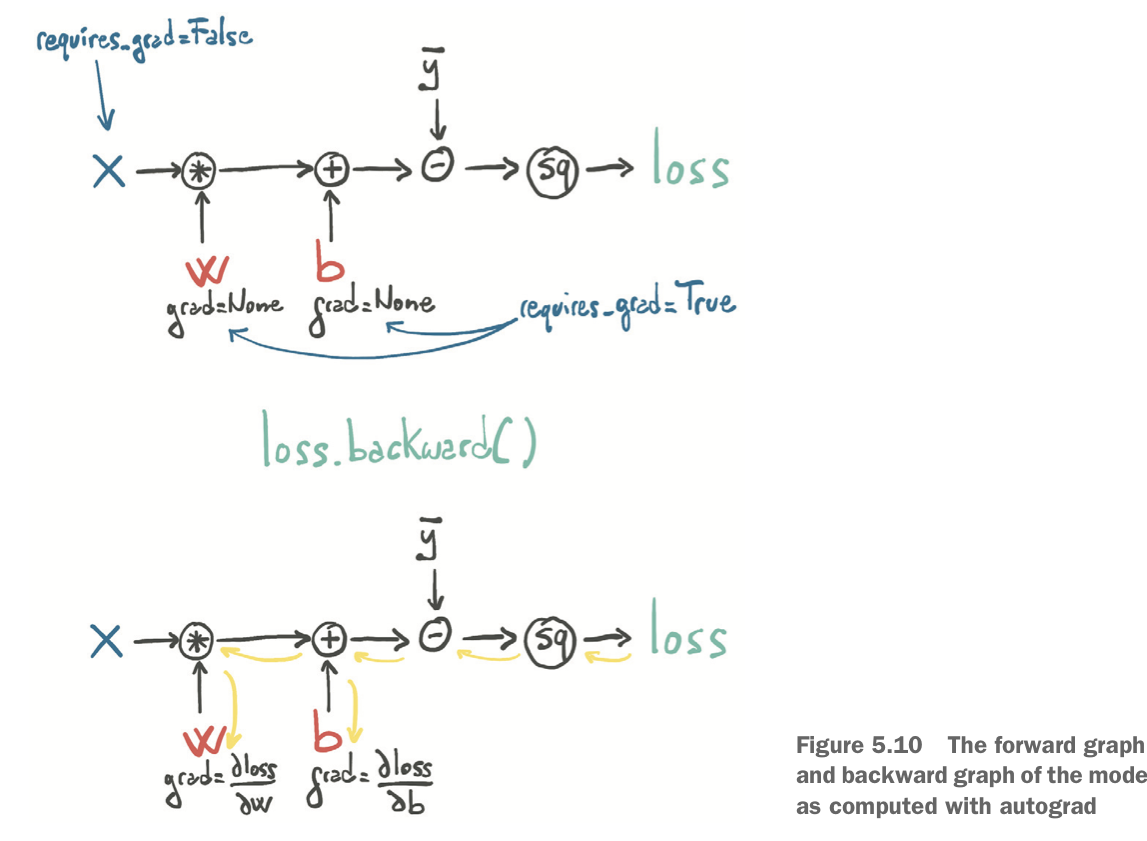

In [234]:
def training_loop_autograd(n_epochs, learning_rate, params, x, t):
    for e in range(n_epochs):
        if params.grad is not None:
            params.grad.zero_()
        M = model(x, *params)
        L = l(M, t)
        L.backward()
        
        with torch.no_grad():
            # the new params tensor will not have a grad attribute
            params = params - learning_rate * params.grad
        # Re-enable grad.
        params.requires_grad_(True)
        
        yield {
            "epoch": e,
            "loss": float(L),
            "params": torch.clone(params)
        }

### Training loop with Pytroch's optimizer and loss functions

In [280]:
import torch.optim as optim
import torch.nn as nn

Here we pass an optimizer to the training loop. That will be a stohastich gradient will, which will follow exactly the same formula what we implemented in the training loop above.

Similary we pass a Pytorch MSE loss function, which is equivalent with our self defined loss function.

In [283]:
def training_loop_optim(n_epochs, optimizer, loss_fn, params, x, t):
    for e in range(n_epochs):
        M = model(x, *params)
        L = loss_fn(M, t)
        
        # gradients are accumlated inside tensors and not overwrittens
        # This will zero out the gradients for the params tensor
        optimizer.zero_grad()
        # Calculate the gradients against the loss `L`
        L.backward()
        # Update the parametes using the calculated gradients
        optimizer.step()
        
        
        yield {
            "epoch": e,
            "loss": float(L),
            "params": torch.clone(params)
        }

In [284]:
x = torch.tensor(df_train["petal_length"])

In [285]:
t = torch.tensor(df_train["sepal_length"])

## Run training loops

Autograd loop

In [294]:
params = torch.tensor([0.1, 0.0], requires_grad=True)
params

tensor([0.1000, 0.0000], requires_grad=True)

In [295]:
epochs_autograd = training_loop_autograd(
    EPOCHS,
    LEARNING_RATE,
    params,
    x,
    t
)

Optimizer loop

In [296]:
params_optim = torch.tensor([0.1, 0.0], requires_grad=True)
params_optim

tensor([0.1000, 0.0000], requires_grad=True)

In [297]:
optimizer = optim.SGD([params_optim], lr=LEARNING_RATE)

In [298]:
mse_loss = nn.MSELoss()

In [299]:
epochs_optim = training_loop_optim(
    EPOCHS,
    optimizer,
    mse_loss,
    params_optim,
    x,
    t
)

## Visualize line fitting epoch-by-epoch

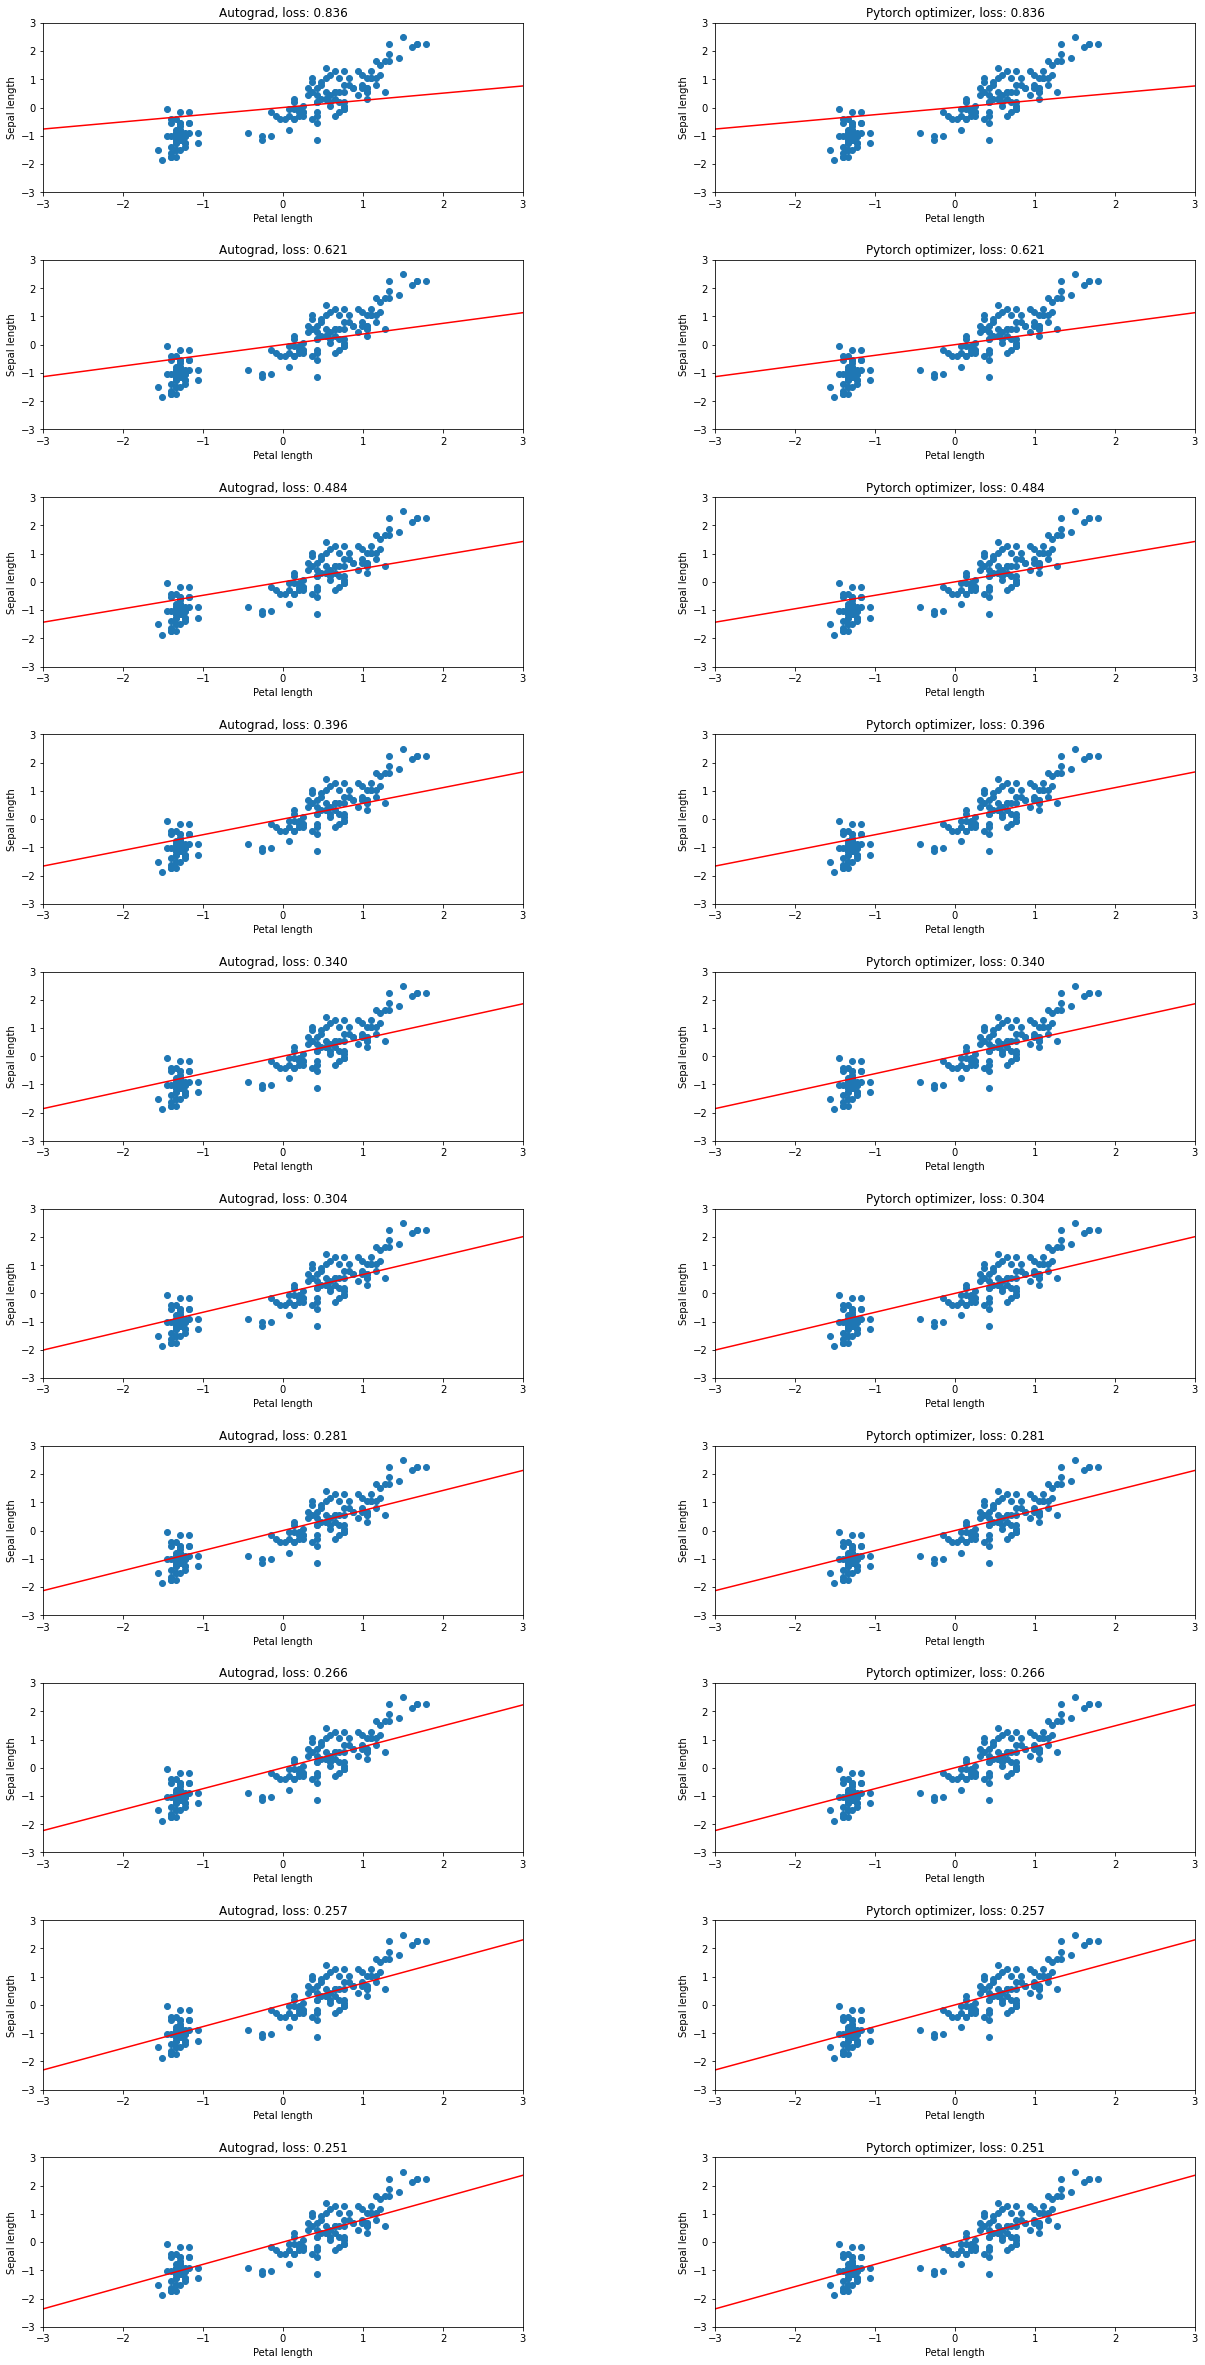

In [300]:
fig, axs = plt.subplots(
    nrows=EPOCHS,
    ncols=2,
    figsize=(20, 40)
)

L_arr_autograd = np.empty(EPOCHS)
for e in epochs_autograd:
    i = e["epoch"]
    w = float(e["params"][0])
    b = float(e["params"][1])
    L = e["loss"]
    
    L_arr_autograd[i] = L
    
    
    
    x_line = np.array([-3, 3])
    y_line = x_line * w + b
    axs[i, 0].plot(x_line, y_line, "r")
    
    axs[i, 0].scatter(
        df_train["petal_length"],
        df_train["sepal_length"]
    )
    
    axs[i, 0].set_xlim([-3, 3])
    axs[i, 0].set_ylim([-3, 3])
    axs[i, 0].title.set_text(f"Autograd, loss: {L:.3f}")
    axs[i, 0].set_xlabel("Petal length")
    axs[i, 0].set_ylabel("Sepal length")

L_arr_optim = np.empty(EPOCHS)
for e in epochs_optim:
    i = e["epoch"]
    w = float(e["params"][0])
    b = float(e["params"][1])
    L = e["loss"]
    
    
    L_arr_optim[i] = L
    
    
    
    x_line = np.array([-3, 3])
    y_line = x_line * w + b
    axs[i, 1].plot(x_line, y_line, "r")
    
    axs[i, 1].scatter(
        df_train["petal_length"],
        df_train["sepal_length"]
    )
    
    axs[i, 1].set_xlim([-3, 3])
    axs[i, 1].set_ylim([-3, 3])
    axs[i, 1].title.set_text(f"Pytorch optimizer, loss: {L:.3f}")
    axs[i, 1].set_xlabel("Petal length")
    axs[i, 1].set_ylabel("Sepal length")
    
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9,
                    wspace=0.4, 
                    hspace=0.4)


## Visualize the change in loss epoc-by-epoch

Text(0, 0.5, 'loss')

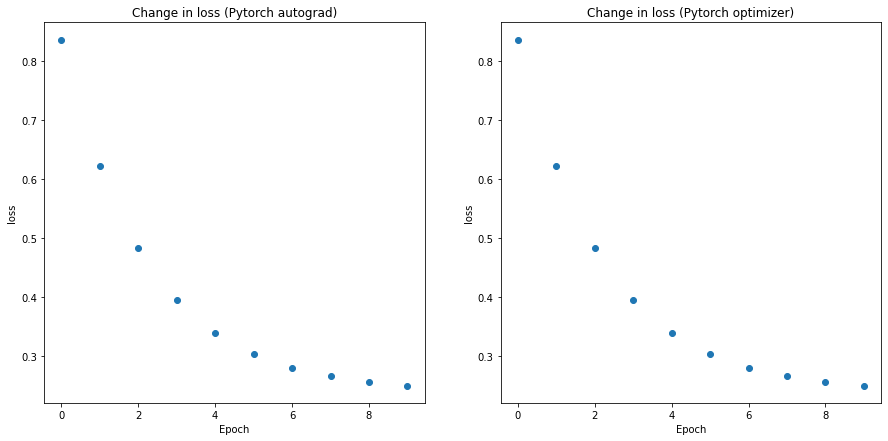

In [279]:
fig, axs = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(15, 7)
)

axs[0].scatter(
    np.array(range(EPOCHS)),
    L_arr_autograd
)
axs[0].title.set_text("Change in loss (Pytorch autograd)")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("loss")

axs[1].scatter(
    np.array(range(EPOCHS)),
    L_arr_optim
)
axs[1].title.set_text("Change in loss (Pytorch optimizer)")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("loss")